In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Column names based on NSL-KDD dataset structure
col_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 
    'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
    'dst_host_srv_count', 'dst_host_same_srv_rate', 
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
    'dst_host_srv_rerror_rate', 'class', 'difficulty'
]

# Loading the dataset (using atleast 10% -> therefore choosing the 20% subset)
train_path = 'NSL-KDD Archive/KDDTrain+_20Percent.txt'
df = pd.read_csv(train_path, header=None, names=col_names)

print("Dataset shape:", df.shape)
print("\nFirst few rows of the dataset:")
df.head()


Dataset shape: (25192, 43)

First few rows of the dataset:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [64]:
# Identify feature types
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('class') if 'class' in numeric_features else None
numeric_features.remove('difficulty') if 'difficulty' in numeric_features else None

categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("\nNumerical features:", len(numeric_features))
print(numeric_features)
print("\nCategorical features:", len(categorical_features))
print(categorical_features)



Numerical features: 38
['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

Categorical features: 4
['protocol_type', 'service', 'flag', 'class']


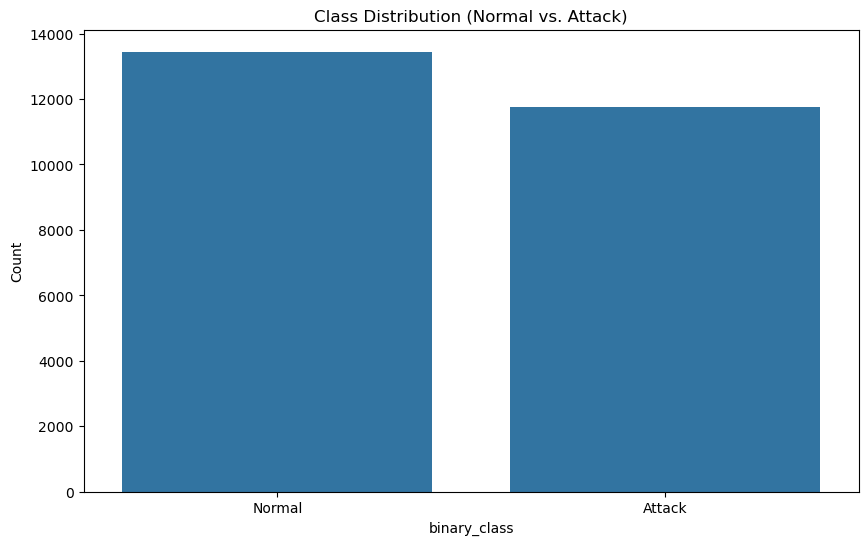


Class distribution (binary):
binary_class
Normal    13449
Attack    11743
Name: count, dtype: int64

Class distribution (percentage):
binary_class
Normal    53.385996
Attack    46.614004
Name: proportion, dtype: float64


In [66]:
# Create a binary classification column
df['binary_class'] = df['class'].apply(lambda x: 'Normal' if x == 'normal' else 'Attack')

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='binary_class', data=df)
plt.title('Class Distribution (Normal vs. Attack)')
plt.ylabel('Count')
plt.show()

# Check for class imbalance
print("\nClass distribution (binary):")
print(df['binary_class'].value_counts())
print("\nClass distribution (percentage):")
print(df['binary_class'].value_counts(normalize=True) * 100)


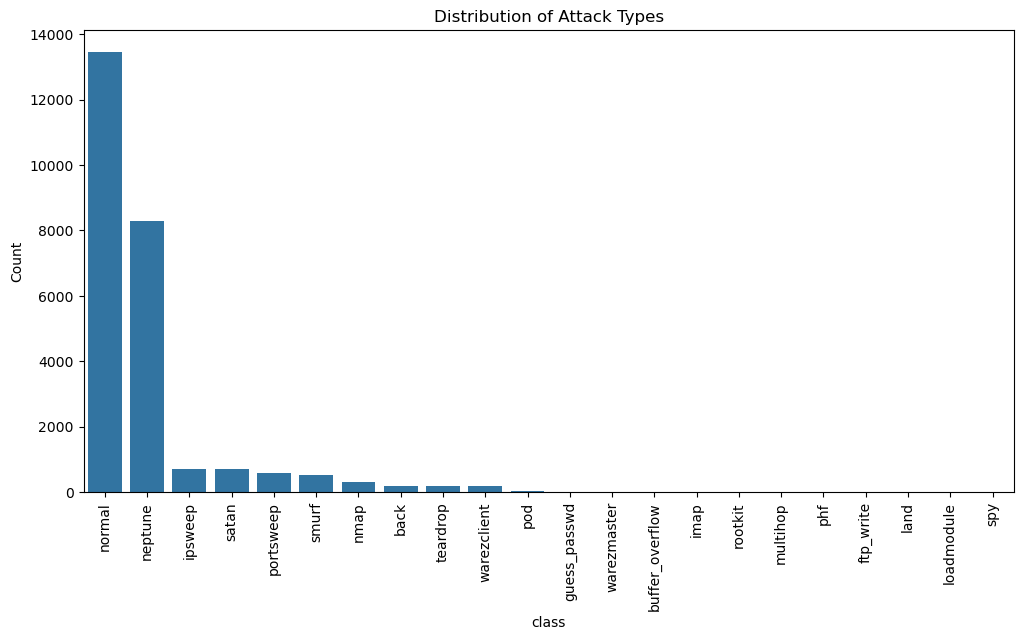

In [68]:
# Plot distribution of attack types
plt.figure(figsize=(12, 6))
sns.countplot(x='class', data=df, order=df['class'].value_counts().index)
plt.title('Distribution of Attack Types')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


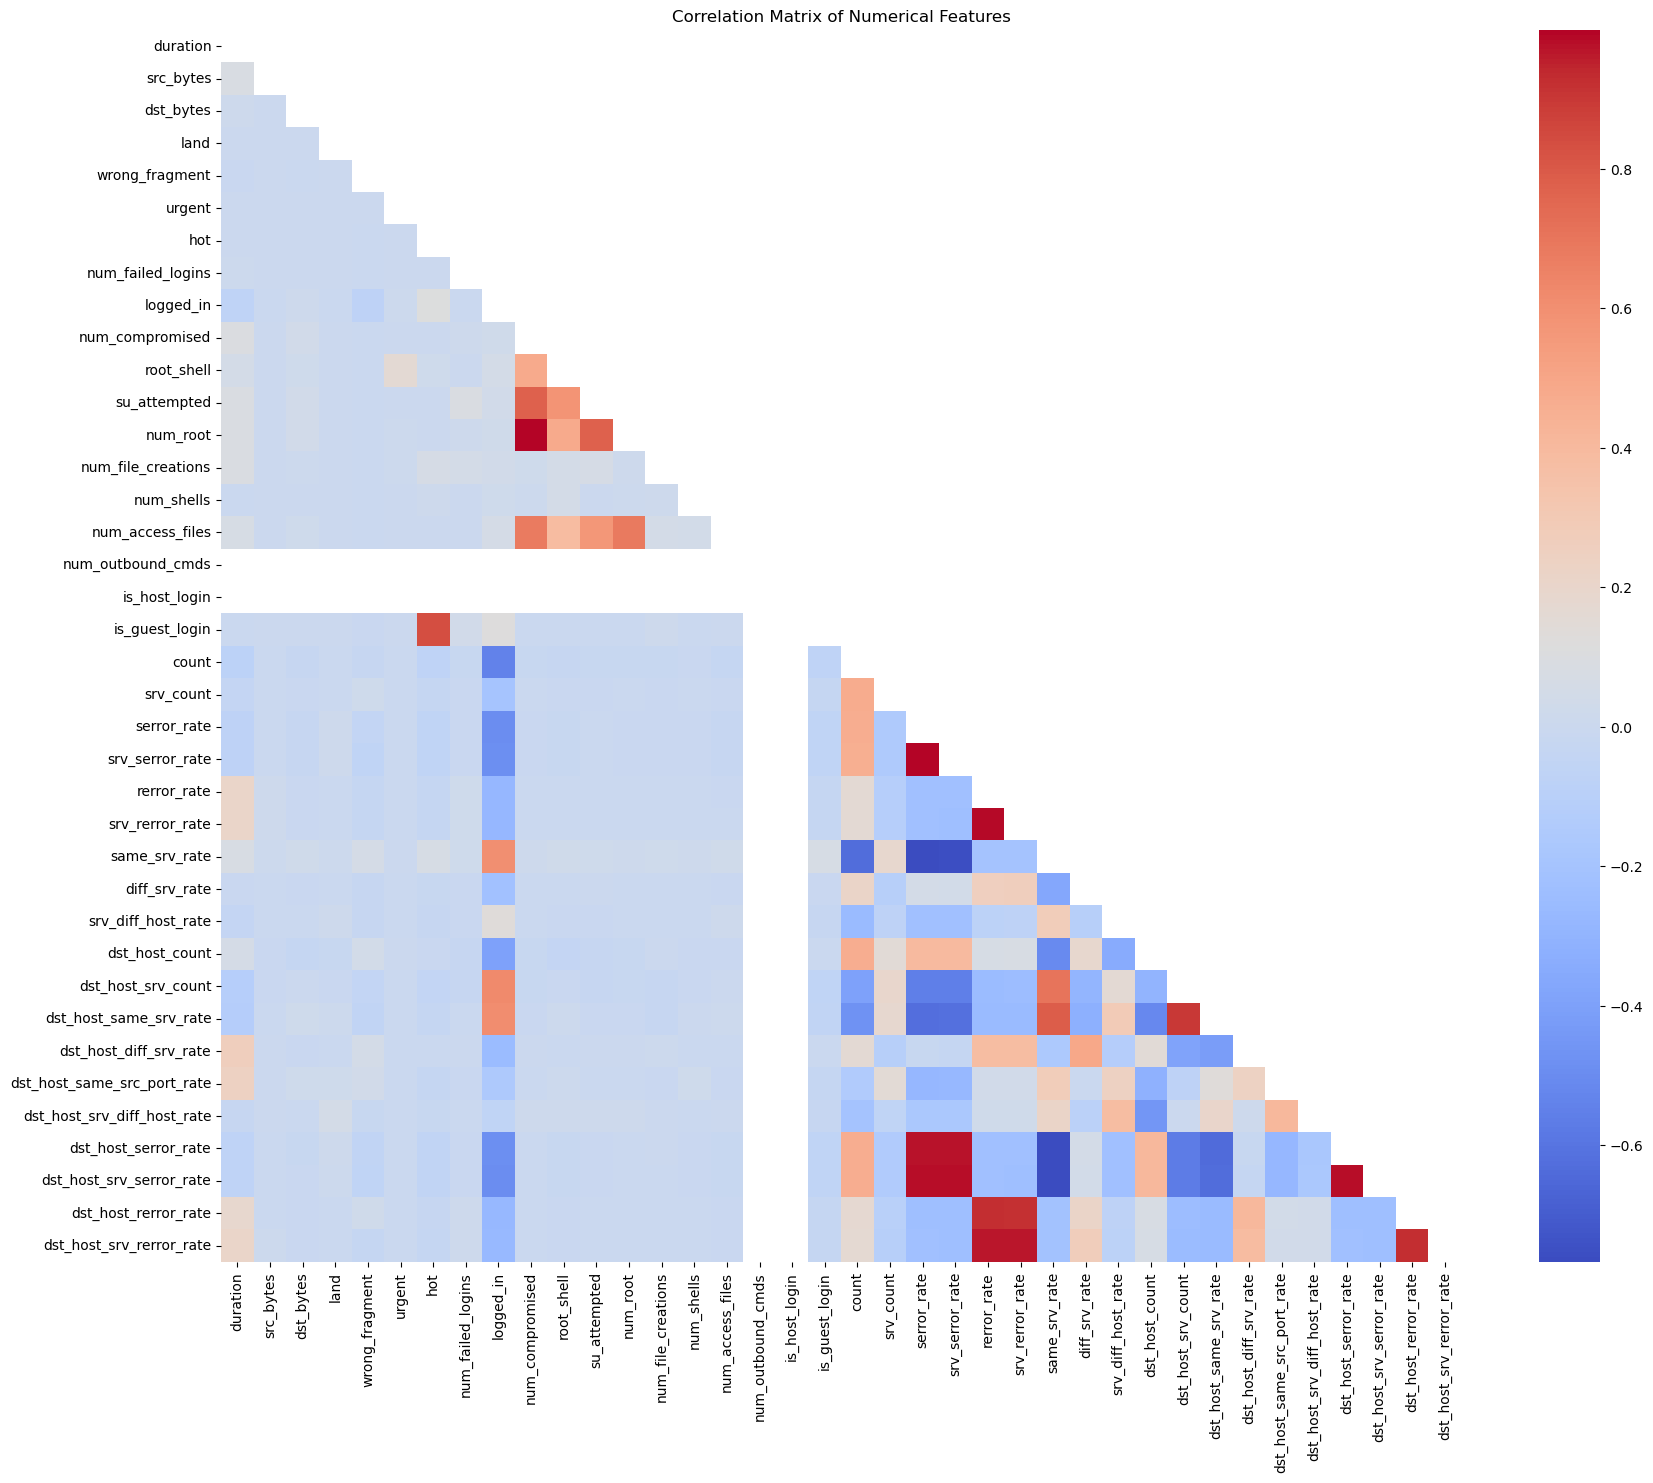


Top 10 feature pairs with highest correlation:
num_root and num_compromised: 0.9990
su_attempted and num_compromised: 0.7763
num_root and su_attempted: 0.7741
num_access_files and num_root: 0.6842
num_access_files and num_compromised: 0.6806
su_attempted and root_shell: 0.5784
num_access_files and su_attempted: 0.5687
count and logged_in: -0.5399
num_root and root_shell: 0.4802
root_shell and num_compromised: 0.4795


In [70]:
# Check for feature correlation (heat map)
plt.figure(figsize=(20, 16))
correlation = df[numeric_features].corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=False, mask=mask, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Look at the top correlated features
print("\nTop 10 feature pairs with highest correlation:")
corr_pairs = []
for i in range(len(correlation.columns)):
    for j in range(i):
        corr_pairs.append((correlation.columns[i], correlation.columns[j], correlation.iloc[i, j]))
corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for pair in corr_pairs[:10]:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.4f}")


In [78]:
# Data preprocessing
# Drop the 'difficulty' column as it's not needed for classification
# df = df.drop('difficulty', axis=1)

# Convert binary_class to numerical (0 for Normal, 1 for Attack)
df['binary_target'] = df['binary_class'].apply(lambda x: 0 if x == 'Normal' else 1)

# Log transformation for highly skewed numerical features
log_features = ['duration', 'src_bytes', 'dst_bytes']

for feature in log_features:
    # Add a small constant (1) to avoid log(0)
    df[feature + '_log'] = np.log1p(df[feature])

# Prepare the feature set and target variable
X = df.drop(['class', 'binary_class', 'binary_target'], axis=1)
y = df['binary_target']

# Identify numerical and categorical columns for preprocessing
numerical_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")

# Create pipelines for each model that include preprocessing
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42))
])

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])


Training set shape: (17634, 44), Testing set shape: (7558, 44)


In [82]:
# Function to evaluate a model using 5-fold cross-validation
def evaluate_model_cv(model, X, y, model_name):
    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Metrics to collect
    cv_accuracy = []
    cv_precision = []
    cv_recall = []
    cv_f1 = []
    
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred = model.predict(X_test_fold)
        
        # Calculate metrics
        cv_accuracy.append(accuracy_score(y_test_fold, y_pred))
        cv_precision.append(precision_score(y_test_fold, y_pred))
        cv_recall.append(recall_score(y_test_fold, y_pred))
        cv_f1.append(f1_score(y_test_fold, y_pred))
    
    # Print results
    print(f"\n{model_name} - 5-fold Cross-Validation Results:")
    print(f"Accuracy: {np.mean(cv_accuracy):.4f} (±{np.std(cv_accuracy):.4f})")
    print(f"Precision: {np.mean(cv_precision):.4f} (±{np.std(cv_precision):.4f})")
    print(f"Recall: {np.mean(cv_recall):.4f} (±{np.std(cv_recall):.4f})")
    print(f"F1-score: {np.mean(cv_f1):.4f} (±{np.std(cv_f1):.4f})")
    
    return {
        'model_name': model_name,
        'accuracy': np.mean(cv_accuracy),
        'precision': np.mean(cv_precision),
        'recall': np.mean(cv_recall),
        'f1': np.mean(cv_f1)
    }

# Evaluate models using cross-validation
results_cv = []
results_cv.append(evaluate_model_cv(rf_pipeline, X, y, "Random Forest"))
results_cv.append(evaluate_model_cv(svm_pipeline, X, y, "Support Vector Machine"))
results_cv.append(evaluate_model_cv(lr_pipeline, X, y, "Logistic Regression"))



Random Forest - 5-fold Cross-Validation Results:
Accuracy: 0.9981 (±0.0005)
Precision: 0.9991 (±0.0003)
Recall: 0.9969 (±0.0007)
F1-score: 0.9980 (±0.0005)

Support Vector Machine - 5-fold Cross-Validation Results:
Accuracy: 0.9932 (±0.0016)
Precision: 0.9924 (±0.0029)
Recall: 0.9930 (±0.0017)
F1-score: 0.9927 (±0.0017)

Logistic Regression - 5-fold Cross-Validation Results:
Accuracy: 0.9749 (±0.0027)
Precision: 0.9800 (±0.0056)
Recall: 0.9658 (±0.0042)
F1-score: 0.9728 (±0.0030)



Random Forest - Test Set Results:
Accuracy: 0.9971
Precision: 0.9989
Recall: 0.9949
F1-score: 0.9969


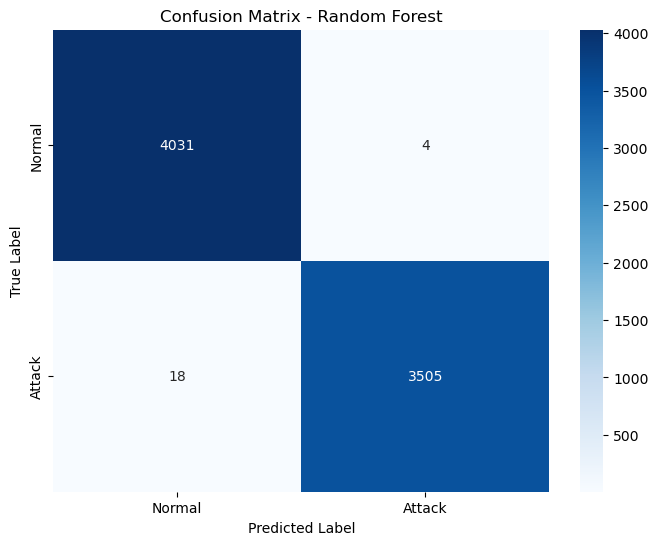


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4035
      Attack       1.00      0.99      1.00      3523

    accuracy                           1.00      7558
   macro avg       1.00      1.00      1.00      7558
weighted avg       1.00      1.00      1.00      7558


Support Vector Machine - Test Set Results:
Accuracy: 0.9935
Precision: 0.9926
Recall: 0.9935
F1-score: 0.9930


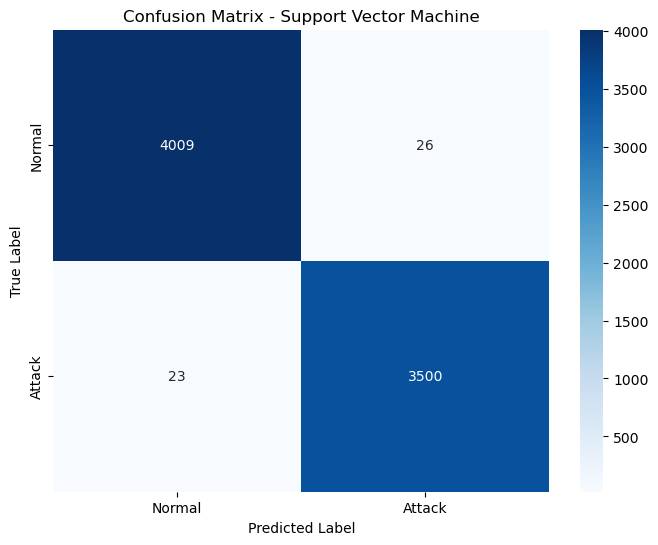


Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99      4035
      Attack       0.99      0.99      0.99      3523

    accuracy                           0.99      7558
   macro avg       0.99      0.99      0.99      7558
weighted avg       0.99      0.99      0.99      7558


Logistic Regression - Test Set Results:
Accuracy: 0.9730
Precision: 0.9789
Recall: 0.9628
F1-score: 0.9708


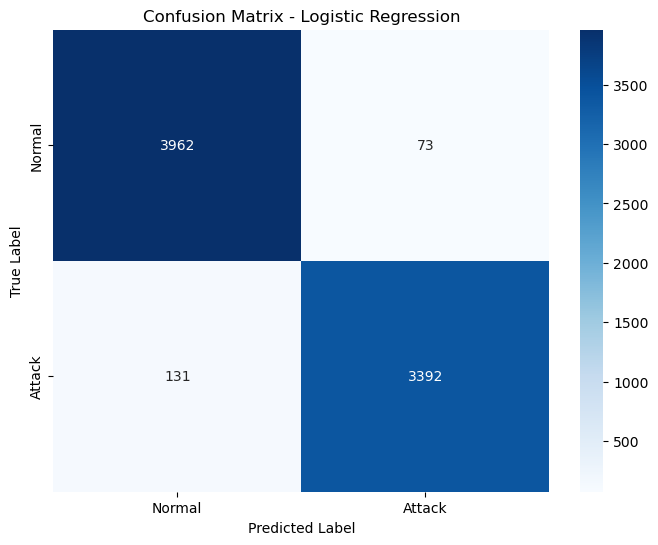


Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97      4035
      Attack       0.98      0.96      0.97      3523

    accuracy                           0.97      7558
   macro avg       0.97      0.97      0.97      7558
weighted avg       0.97      0.97      0.97      7558



In [88]:
# Function to evaluate model on train-test split
def evaluate_model_test(model, X_train, X_test, y_train, y_test, model_name):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} - Test Set Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Attack']))
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix
    }

# Evaluate models using train-test split
results_test = []
results_test.append(evaluate_model_test(rf_pipeline, X_train, X_test, y_train, y_test, "Random Forest"))
results_test.append(evaluate_model_test(svm_pipeline, X_train, X_test, y_train, y_test, "Support Vector Machine"))
results_test.append(evaluate_model_test(lr_pipeline, X_train, X_test, y_train, y_test, "Logistic Regression"))



Cross-Validation Results Comparison:
                        accuracy  precision    recall        f1
model_name                                                     
Random Forest           0.998134   0.999061  0.996933  0.997996
Support Vector Machine  0.993212   0.992425  0.993013  0.992716
Logistic Regression     0.974873   0.980047  0.965773  0.972842

Test Set Results Comparison:
                        accuracy  precision    recall        f1
model_name                                                     
Random Forest           0.997089   0.998860  0.994891  0.996871
Support Vector Machine  0.993517   0.992626  0.993471  0.993049
Logistic Regression     0.973009   0.978932  0.962816  0.970807


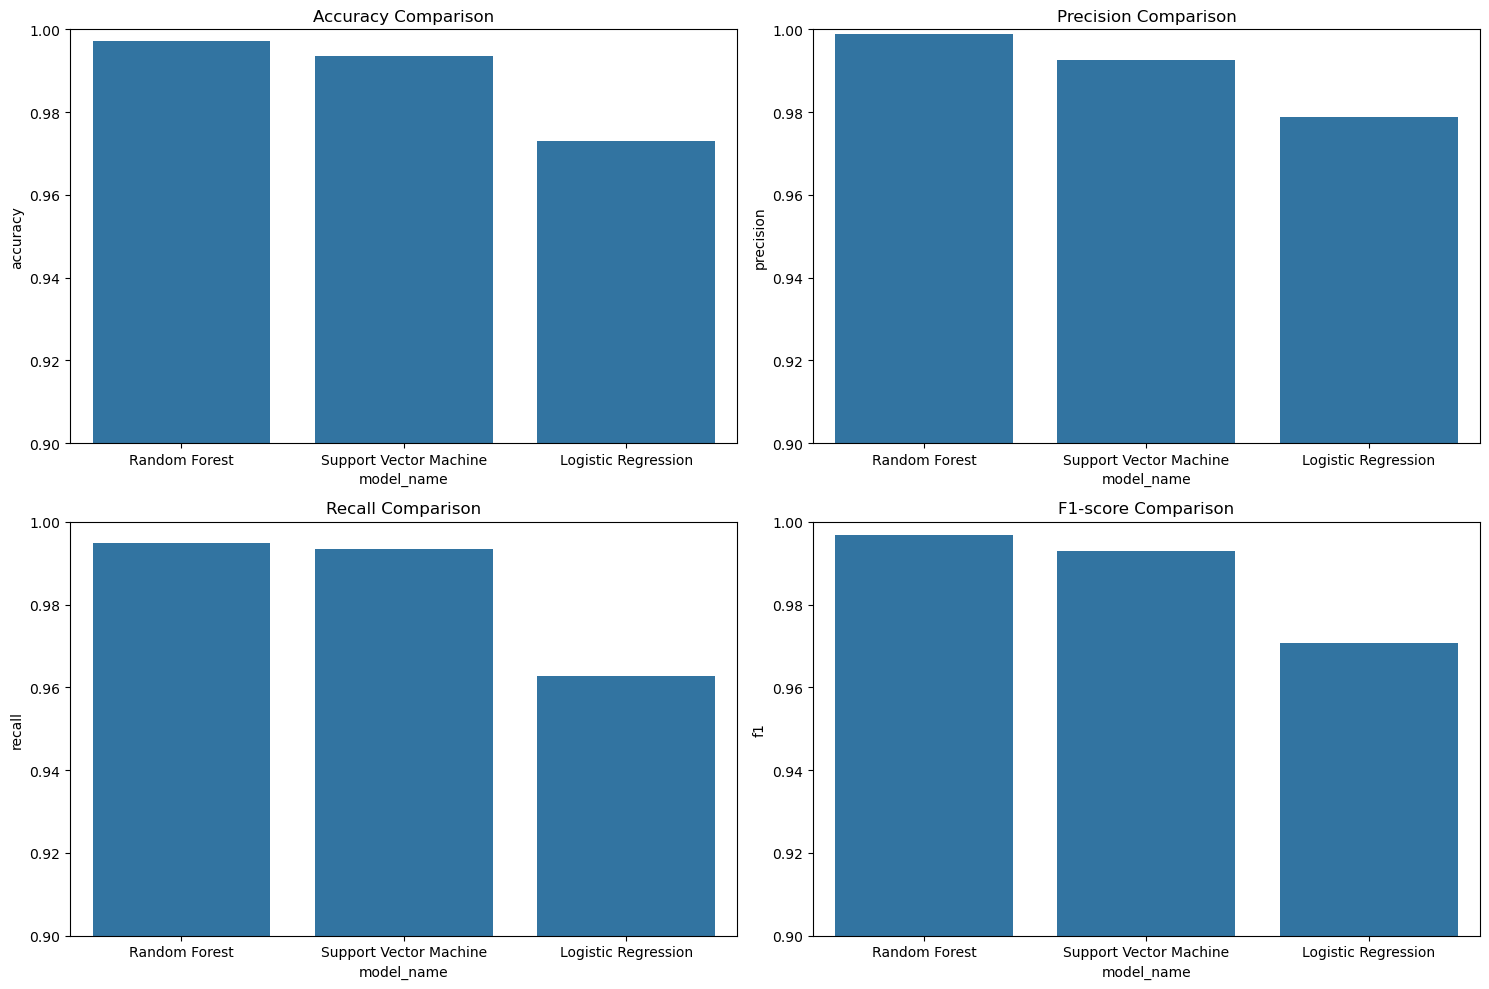

In [86]:
# Create a DataFrame to compare models
cv_results_df = pd.DataFrame(results_cv)
test_results_df = pd.DataFrame(results_test)

print("\nCross-Validation Results Comparison:")
print(cv_results_df.set_index('model_name'))

print("\nTest Set Results Comparison:")
print(test_results_df[['model_name', 'accuracy', 'precision', 'recall', 'f1']].set_index('model_name'))

# Visualize model comparison
plt.figure(figsize=(15, 10))

# Plot accuracy comparison
plt.subplot(2, 2, 1)
sns.barplot(x='model_name', y='accuracy', data=test_results_df)
plt.title('Accuracy Comparison')
plt.ylim(0.9, 1.0)

# Plot precision comparison
plt.subplot(2, 2, 2)
sns.barplot(x='model_name', y='precision', data=test_results_df)
plt.title('Precision Comparison')
plt.ylim(0.9, 1.0)

# Plot recall comparison
plt.subplot(2, 2, 3)
sns.barplot(x='model_name', y='recall', data=test_results_df)
plt.title('Recall Comparison')
plt.ylim(0.9, 1.0)

# Plot F1-score comparison
plt.subplot(2, 2, 4)
sns.barplot(x='model_name', y='f1', data=test_results_df)
plt.title('F1-score Comparison')
plt.ylim(0.9, 1.0)

plt.tight_layout()
plt.show()
